In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import random

# 1 模型定义
### 线性回归假设输出与各个输入之间是线性关系，有如下定义:
## <center> y = wX + b </center>
### 为训练线性回归，我们构造一个人工的训练数据集，利用真实权重w = [2]，偏差b=4.2的回归方程加上一个随机噪声项ϵ来生成数据，ϵ服从均值为0，标准差为0.01的正态分布。最终得到数据集共有1000个样本，输入特征数为1，输出特征数为1。下文代码生成数据并得到真实函数图像与噪声点分布图像
## <center> y = wX + b + ϵ </center>
> 噪声项的加入是为了更好地模拟真实世界数据，真实世界很多情况不能简单地用线性函数来表示，一般是有误差的，模型仅能最大化地拟合数据

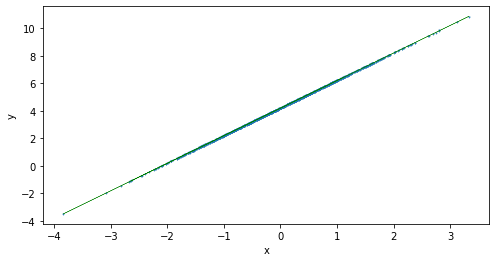

In [2]:
x_feature_num = 1 # 输入特征数
x_num = 1000 # 样本数量
true_w = [2] # 真实权重
true_b = 4.2 # 偏差量
x = tf.random.normal((x_num, x_feature_num),stddev = 1) # x
y = true_w[0] * x[:,0] + true_b # y
y_noise = y + tf.random.normal(y.shape,stddev=0.01) # y+noise

# 生成图像
plt.figure(figsize=(8,4))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y_noise, 1,marker='v')
plt.plot(x,y,color='g',linewidth = '0.4')
plt.show()

# 2 模型训练
### 初始化模型权重w_m以及偏差b_m，我们利用生成的训练数据训练模型，定义损失函数利用优化算法最小化损失函数并更新权重，最终获得接近真实权重w和偏差b的权重w_m以及偏差b_m。

In [3]:
w_m = tf.Variable(tf.random.normal((x_feature_num, 1), stddev=0.01))
b_m = tf.Variable(tf.zeros((1,)))

## 2.1 定义模型

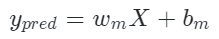

In [4]:
def linreg(X, w, b):
    return tf.matmul(X, w) + b

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import initializers as init
model = keras.Sequential()
model.add(layers.Dense(1, kernel_initializer=init.RandomNormal(stddev=0.5)))

## 2.2 定义损失函数
### 在模型训练中，我们需要衡量价格预测值与真实值之间的误差。通常我们会选取一个非负数作为误差，且数值越小表示误差越小。一个常用的选择是平方函数。模型训练中，我们希望找出一组模型参数，来使训练样本平均损失最小。
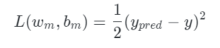

In [5]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 /2

from tensorflow import losses
loss = losses.MeanSquaredError()

## 2.3 定义优化算法
### 当模型和损失函数形式较为简单时，上面的误差最小化问题的解可以直接用公式表达出来。这类解叫作解析解（analytical solution）。本节使用的线性回归和平方误差刚好属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。这类解叫作数值解（numerical solution）。

### 在求数值解的优化算法中，小批量随机梯度下降（mini-batch stochastic gradient descent）在深度学习中被广泛使用。它的算法很简单：先选取一组模型参数的初始值，如随机选取；接下来对参数进行多次迭代，使每次迭代都可能降低损失函数的值。在每次迭代中，先随机均匀采样一个由固定数目训练数据样本所组成的小批量（mini-batch）B，然后求小批量中数据样本的平均损失有关模型参数的导数（梯度），最后用此结果与预先设定的一个正数的乘积作为模型参数在本次迭代的减小量。
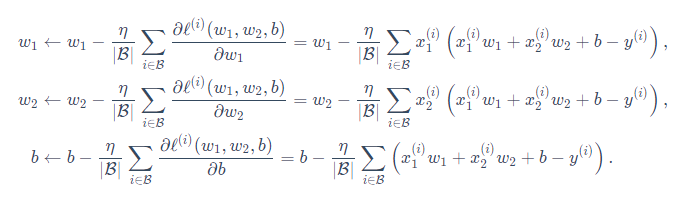

In [6]:
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)

from tensorflow.keras import optimizers
trainer = optimizers.SGD(learning_rate=0.03)

### 2.4 构造数据并训练模型
#### 定义超参

In [7]:
lr = 0.03 # 学习率
num_epochs = 3 
batch_size = 10 

In [8]:
from tensorflow import data as tfdata


# 将训练数据的特征和标签组合
dataset = tfdata.Dataset.from_tensor_slices((x, y_noise))
# 随机读取小批量
dataset = dataset.shuffle(buffer_size=x_num) # 随机排列数据
dataset = dataset.batch(batch_size)

### LR模型-1

In [9]:
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for (batch, (X, y)) in enumerate(dataset):
        with tf.GradientTape() as t:
            t.watch([w_m,b_m])
            l = loss(net(X, w_m, b_m), y)
        grads = t.gradient(l, [w_m, b_m])
        sgd([w_m, b_m], lr, batch_size, grads)
    train_l = loss(net(x, w_m, b_m), y_noise)
    print('epoch %d, loss %f' % (epoch, tf.reduce_mean(train_l)))


epoch 0, loss 0.025467
epoch 1, loss 0.000108
epoch 2, loss 0.000047


#### 比较学到的参数和用来生成训练集的真实参数

In [10]:
print(true_w, w_m.numpy())
print(true_b, b_m.numpy())

[2] [[1.9997469]]
4.2 [4.199144]


### LR模型-2
#### 在使用Tensorflow训练模型时，我们通过调用tensorflow.GradientTape记录动态图梯度，执行tape.gradient获得动态图中各变量梯度。通过 model.trainable_variables 找到需要更新的变量，并用 trainer.apply_gradients 更新权重，完成一步训练。

In [11]:
for epoch in range(num_epochs):
    for (batch, (X, y)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            l = loss(model(X, training=True), y)

        grads = tape.gradient(l, model.trainable_variables)
        trainer.apply_gradients(zip(grads, model.trainable_variables))

    l = loss(model(x), y_noise)
    print('epoch %d, loss: %f' % (epoch, tf.reduce_mean(l)))

epoch 0, loss: 0.000048
epoch 1, loss: 0.000050
epoch 2, loss: 0.000050


#### 我们可以通过model的get_weights()来获得其权重（weight）和偏差（bias）。学到的参数和真实的参数很接近。

In [12]:
print(true_w,model.get_weights()[0])
print(true_b,model.get_weights()[1])

[2] [[1.9976016]]
4.2 [4.2003684]


# 参考文献
- https://trickygo.github.io/Dive-into-DL-TensorFlow2.0/#/chapter03_DL-basics/3.1_linear-regression